In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
# disabling pesky FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

sns.set_theme()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
data_path = Path('/kaggle/input/titanic')
train_df = pd.read_csv(data_path / "train.csv", index_col='PassengerId')
test_df = pd.read_csv(data_path / "test.csv", index_col='PassengerId')

In [3]:
# taking a peek
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(train_df), len(test_df)

(891, 418)

Since there are so few features we can inspect the number of NAs manually

In [5]:
# some high-level description
num_NAs_by_feature_train = train_df.isna().sum()
num_NAs_by_feature_test = test_df.isna().sum()

pd.DataFrame({
    'NAs': num_NAs_by_feature_train,
    'NA %': (num_NAs_by_feature_train / len(train_df) * 100).round(2),
    'Dtype': train_df.dtypes,
    'Unique values': train_df.nunique(),
    '% uniqueness': (train_df.nunique() / len(train_df) * 100).round(2),
    'Mean/mode': [train_df[col].mode()[0] if str(train_df[col].dtype)=='object' 
                  else train_df[col].mean()
                  for col in train_df.columns]
}, index=train_df.columns)

,NAs,NA %,Dtype,Unique values,% uniqueness,Mean/mode
Survived,0,0.00,int64,2,0.22,0.383838
Pclass,0,0.00,int64,3,0.34,2.308642
Name,0,0.00,object,891,100.00,"Abbing, Mr. Anthony"
Sex,0,0.00,object,2,0.22,male
Age,177,19.87,float64,88,9.88,29.699118
SibSp,0,0.00,int64,7,0.79,0.523008
Parch,0,0.00,int64,7,0.79,0.381594
Ticket,0,0.00,object,681,76.43,1601
Fare,0,0.00,float64,248,27.83,32.204208
Cabin,687,77.10,object,147,16.50,B96 B98


In [6]:
# quantiles and variability of numeric features
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


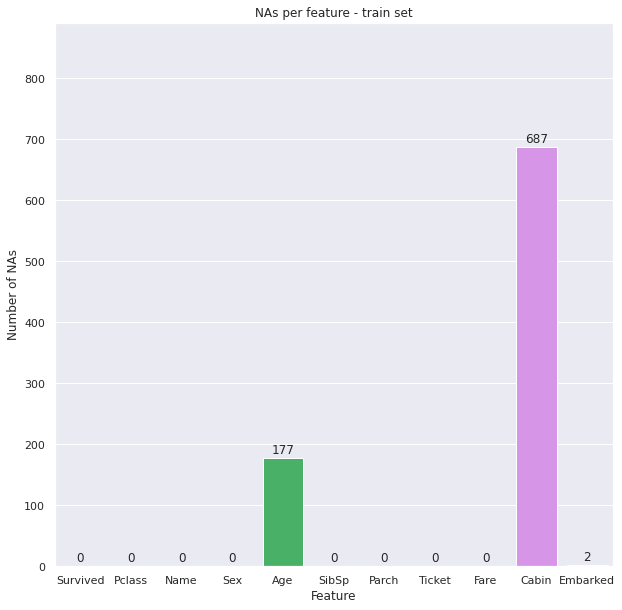

In [7]:
# putting NAs into plots
def annotate_bars(ax):
    for patch in ax.patches:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        ax.annotate(int(y),xy=(x,y), 
                    xytext=(0,8),
                    textcoords='offset points',
                    ha='center', va='center')
        
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.barplot(y=num_NAs_by_feature_train, x=num_NAs_by_feature_train.index)
ax.set_ylim(0, len(train_df))
ax.set_xlabel("Feature")
ax.set_ylabel("Number of NAs")
ax.set_title("NAs per feature - train set")
annotate_bars(ax)

So far we have:
* <20% missing values for *Age*: imputation looks good
* 77.1% (> 3/4) missing values for *Cabin*:
    * If we find it to have good predictive power, we can build 2 different models, one that includes it and another which doesn't.
    * If it doesn't turn out to be a great predictor, it may be viable to drop it altogether.
* 2 (out of 891) missing values for *Embarked*: if the test set has missing values for this feature we can use imputation, if it doesn't we may just drop those two rows.

Now we need to check whether there's another new variable with NAs in the test set which doesn't lack any in the train set.

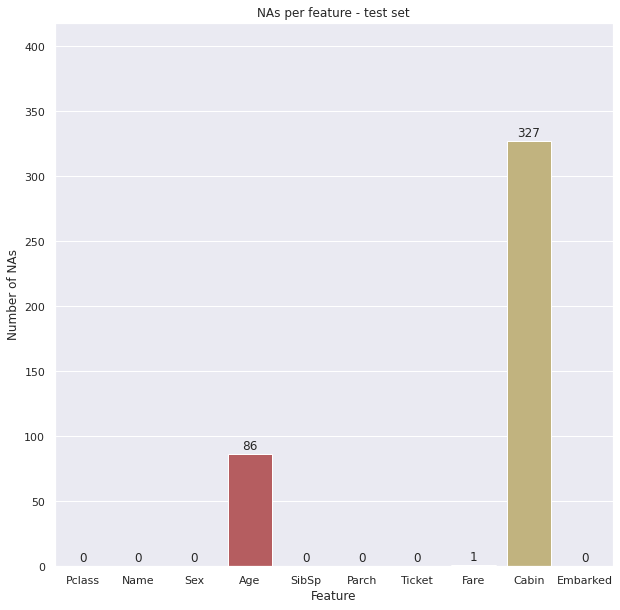

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.barplot(y=num_NAs_by_feature_test, x=num_NAs_by_feature_test.index)
ax.set_ylim(0, len(test_df))
ax.set_xlabel("Feature")
ax.set_ylabel("Number of NAs")
ax.set_title("NAs per feature - test set")
annotate_bars(ax)

* *Cabin* still looks like a very likely-to-be-dropped variable
* *Age* may still need imputation
* One observation misses its *Fare* value. We can use imputation for this one, but more importantly we need to handle it.

## Per-feature analysis

So far we have:
* A binary classification problem with target variable *Survived*
* 1 ordinal categorical variable (*Pclass*)
* 5 nominal categorical variables (*Name*, *Sex*, *Ticket*, *Cabin*, *Embarked*)
* 4 numerical variables (*Age*, *SibSp*, *Parch*, *Fare*)

First we will analize their potential as standalone predictors, then marginal distributions and then how to encode them inside the main pipeline.

In [9]:
# create lists for the pipeline
passthrough_vars = []
drop_vars = []
pipeline_transformers = []

### **Survived**
**Target variable (binary)**

As noted in the description, it's an imbalanced data set. For cat plots we will therefore use % instead of counts, in order to account for such inbalance.
We will try to find whether there's a clear relationship between this target variable and one of the features.

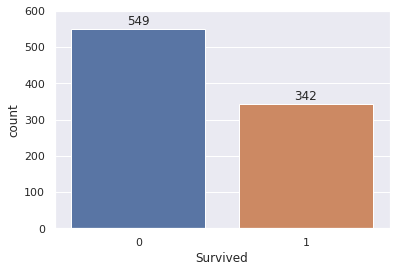

In [10]:
ax = sns.countplot(x='Survived',data=train_df)
ax.set_ylim(0,600)
annotate_bars(ax)

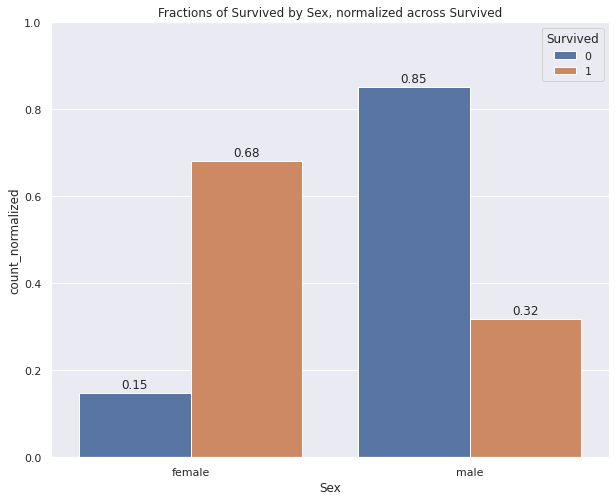

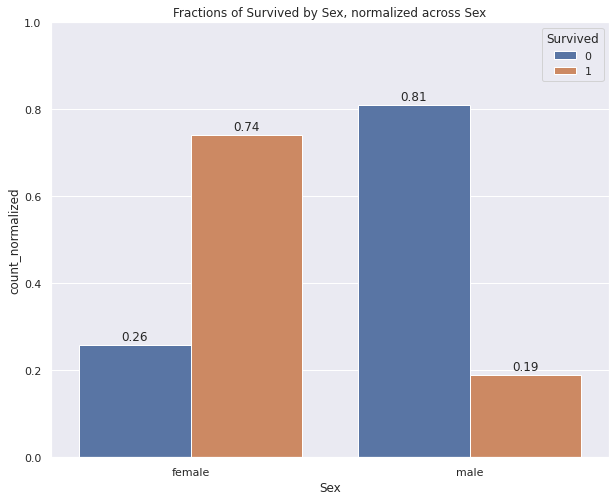

In [11]:
# categorical variables
def cat_vs_cat_plot(first,second,dataset,normalize_on_first=True,figsize=(10,8)):
    df_individual = dataset.groupby([first,second]).size().to_frame(name='count')
    normalizing_var = first if normalize_on_first else second
    df_total = df_individual.groupby(normalizing_var).sum().rename(columns={'count':'total'})
    df_join = df_individual.join(df_total).reset_index()
    df_join['count_normalized'] = df_join['count']/df_join['total']
    
    ax, fig = plt.subplots(figsize=figsize)
    ax = sns.barplot(data=df_join,hue=first,x=second, y='count_normalized')
    ax.set_title(f"Fractions of {first} by {second}, normalized across {normalizing_var}")
    ax.set_ylim(0,1)
    for patch in ax.patches:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        ax.annotate(round(y,2),xy=(x,y), 
                    xytext=(0,8),
                    textcoords='offset points',
                    ha='center', va='center')
    return ax

cat_vs_cat_plot('Survived','Sex',train_df)
plt.show()
cat_vs_cat_plot('Survived','Sex',train_df,normalize_on_first=False)
plt.show()

Note that normalizing on the first variable (*Survived*) provides a better understanding of the "recall", e.g. "what % of the survivors does the 'sex=Male' class hold?" while normalizing on the second variable (*Sex*) shows a better 'precision' perspective, e.g. "what % of the 'sex=Male' class is made of survivors?"

This is how the first plot is commonly done but from a predictive perspective is not as good: the *Survived* variable value is unknown at prediction time, therefore one should look at *Sex* first, then *Survived*, not the other way around

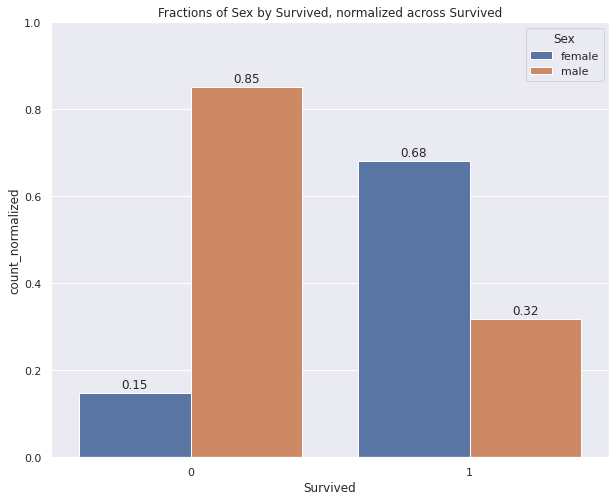

In [12]:
cat_vs_cat_plot('Sex','Survived',train_df,normalize_on_first=False)
plt.show()

Now vs *Embarked*

<AxesSubplot:title={'center':'Fractions of Survived by Embarked, normalized across Survived'}, xlabel='Embarked', ylabel='count_normalized'>

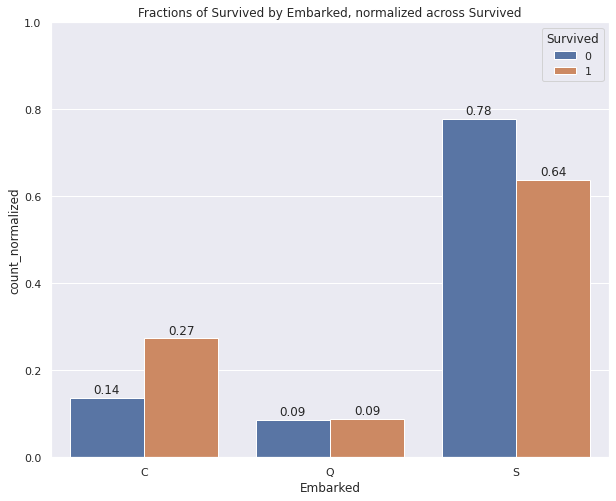

In [13]:
cat_vs_cat_plot('Survived','Embarked',train_df)

<AxesSubplot:title={'center':'Fractions of Survived by Embarked, normalized across Embarked'}, xlabel='Embarked', ylabel='count_normalized'>

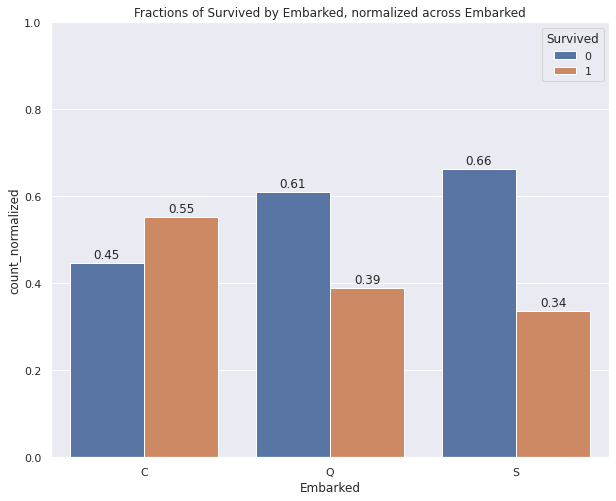

In [14]:
cat_vs_cat_plot('Survived','Embarked',train_df,normalize_on_first=False)

Here we will treat *Pclass* as just another categorical feature, but will normalize across Pclass in order to find specifically how good of a predictor is, discarding imbalances between classes (first class will have less observations than third)

<AxesSubplot:title={'center':'Fractions of Survived by Pclass, normalized across Pclass'}, xlabel='Pclass', ylabel='count_normalized'>

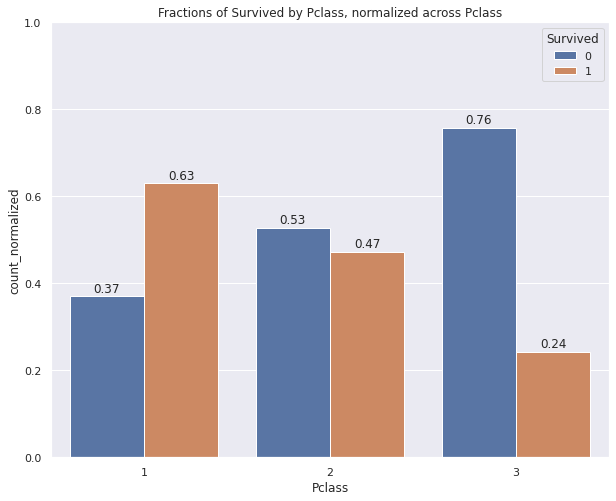

In [15]:
cat_vs_cat_plot('Survived','Pclass',train_df,normalize_on_first=False)

Extreme values for *Pclass* are very good predictors for survival, middle ones not so much. We can expect the same to happen with the *Fare* feature.

<AxesSubplot:xlabel='Survived', ylabel='Age'>

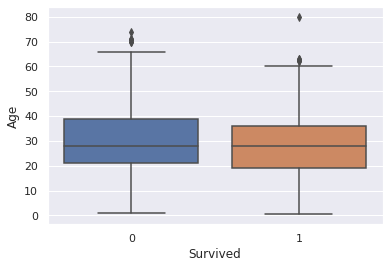

In [16]:
sns.boxplot(data=train_df, y='Age', x='Survived')

Survivors seem to have a stronger presence for the lower values of *Age*, while the rest is dominated by non-survivors (partially due to parents rather saving their kids than themselves, but also just due to the set being imbalanced)

<AxesSubplot:xlabel='Survived', ylabel='SibSp'>

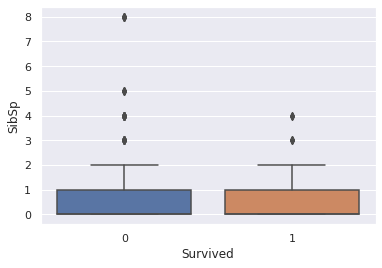

In [17]:
sns.boxplot(data=train_df, y='SibSp', x='Survived')

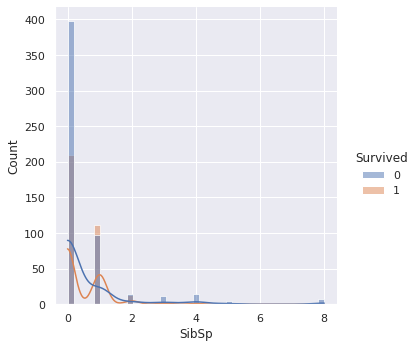

In [18]:
sns.displot(data=train_df, x='SibSp', hue='Survived', kde=True)

No meaningful insight can be drawn from the plots other than :
* SibSp not being a great predictor
* Huge accumulation point on 0
* Very few values despite being a $\mathbb{N}_0$-ranged variable

In [19]:
# doing this the non-fancy way
train_df.SibSp.value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

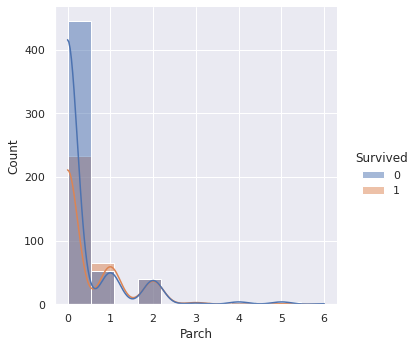

In [20]:
sns.displot(data=train_df, x='Parch', hue='Survived', kde=True)

Same conclusions as with *SibSp*

In [21]:
train_df.Parch.value_counts().sort_index()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

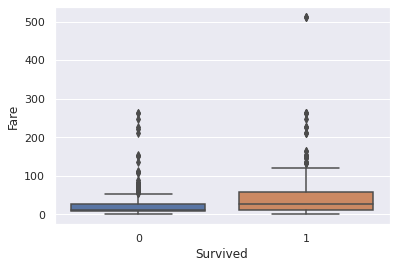

In [22]:
sns.boxplot(data=train_df, y='Fare', x='Survived')

Same as with *Pclass*, this variable looks like a good predictor for survival.

## Pclass

This ordinal categorical feature is somewhat imbalanced but has good predictive power and a manageable range. Will therefore leave it as is.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

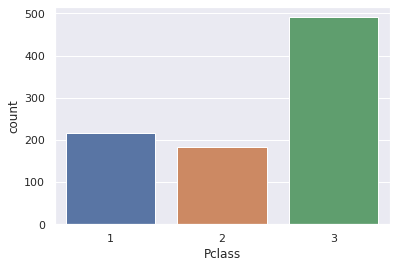

In [23]:
sns.countplot(data=train_df, x='Pclass')

In [24]:
passthrough_vars.append('Pclass')

### Name

Because of its very high cardinality this categorical feature can never work as a predictor as it is. Based on the hypothesis that all names are in the form of < *last_name*, *title*, *name* > (may not be true) there's a possibility that either the last name or the title show lower cardinality and some predictive power.

In [25]:
train_df["Name"].head()

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: object

In [26]:
def lastname_and_title(name_text):
    lastname, title_and_name = name_text.split(",")
    title = title_and_name.split(".")[0]
    return lastname.lower().strip(),title.lower().strip()

lastnames, titles = zip(*train_df.Name.apply(lastname_and_title))
# from tuples to np arrays
lastnames = np.array(lastnames)
titles = np.array(titles)
len(np.unique(lastnames)), len(np.unique(titles))

(667, 17)

While the last names still have very high cardinality, titles work much better. Now to find whether or not they have some predictive power:

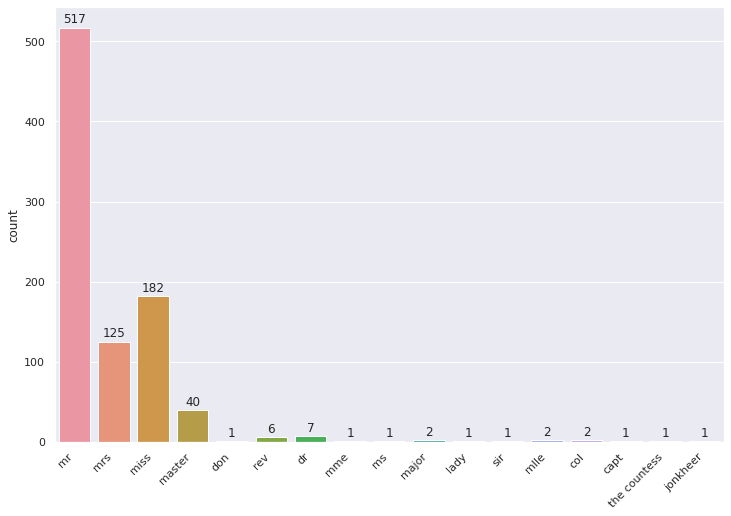

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x=titles, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
annotate_bars(ax)
plt.show()

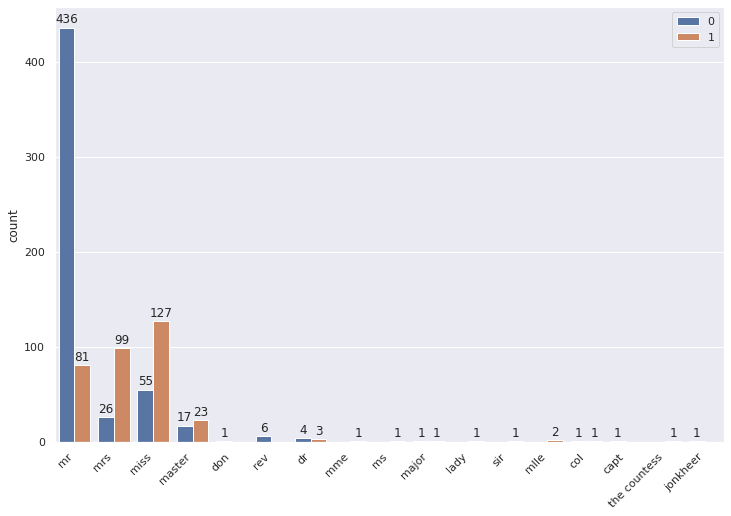

In [28]:
# again but disaggregated by Survival
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x=titles, ax=ax, hue=np.array(train_df.Survived))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#annotate_bars(ax)
# custom annotation as to not break things
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    try: 
        label=int(y) 
    except Exception: 
        label= 0
    ax.annotate(label,xy=(x,y), 
                xytext=(0,8),
                textcoords='offset points',
                ha='center', va='center')
plt.show()

All the 4 main titles (mr, mrs, miss and master) show good predictive power, other values are so sparse that should be binned into a 'other' category (to be then dropped in order to prevent multicollinearity) 

In [29]:
class Name_to_title_encoder(BaseEstimator, TransformerMixin):
    def __init__(self,encoded_names):
        self.encoded_names = frozenset(encoded_names)
        
    def _parse_one_row(self, text):
        # text should be of the form <lastname>, <title>. <rest>
        try:
            title = text.split(",")[1].split(".")[0].lower().strip()
            return title if title in self.encoded_names else "other"
        except Exception as e:
            print(e)
            raise ValueError()
            return "unknown"
        
    def fit(self,X,y):
        return self
    
    def transform(self, name_series):
        return name_series.apply(self._parse_one_row).rename("title").to_frame()

In [30]:
# demonstrate usage of custom transformer
encodable_names = ['mr','mrs','miss','master']
m = Name_to_title_encoder(encoded_names=encodable_names)
m.fit(train_df.drop(columns=["Survived"]), train_df['Survived'])
result = m.transform(train_df['Name'])
print(result.value_counts())
print(len(result))

title 
mr        517
miss      182
mrs       125
master     40
other      27
dtype: int64
891


In [31]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.cols)

In [32]:
# make a pipeline to one-hot encode, then drop the title_other category
# this wont work as OneHotEncoder returns an array instead of a DataFrame
"""
name_title_pipe = Pipeline(steps=[
    ('name_encoder', Name_to_title_encoder(encoded_names=encodable_names)),
    ('one-hot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('other-dropper', ColumnDropper(drop_columns=['title_other']))
])

name_title_pipe.fit_transform(train_df['Name'],train_df.Survived)
"""
# so not deleting the column yet
class NameTitlePipWrapper(Pipeline):
    def __init__(self, steps):
        self.pip = Pipeline(steps)
    
    def get_feature_names(self):
        # hardcoded behavior
        return name_title_pipe.pip[1].get_feature_names(["title"])
    
    def __getattr__(self, name):
        return self.pip.__getattribute__(name)
    
    def __hasattr__(self, name):
        return self.pip.__hasattribute__(name)

name_title_pipe = NameTitlePipWrapper(steps=[
    ('name_encoder', Name_to_title_encoder(encoded_names=encodable_names)),
    ('one-hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

name_title_pipe.fit_transform(train_df['Name'],train_df.Survived).sum(axis=0)

array([ 40., 182., 517., 125.,  27.])

In [33]:
# check usage
name_title_pipe.get_feature_names()

array(['title_master', 'title_miss', 'title_mr', 'title_mrs',
       'title_other'], dtype=object)

In [34]:
# add to the pipeline
pipeline_transformers.append(
    ('name-to-title',name_title_pipe, 'Name')
)

### Sex

As a binary feature, we want to encode this as 0 vs 1, where "female" is chosen for the 1 value as it correlates positively with survival.

In [35]:
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, positive):
        self.positive = positive
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return (X == self.positive).astype(int).to_frame()
    
    def get_feature_names(self):
        return ["is_"+self.positive]

In [36]:
# show usage
sex_positive_label = "female"
BinaryEncoder(sex_positive_label).transform(train_df["Sex"])

,Sex
PassengerId,
1,0
2,1
3,1
4,1
5,0
...,...
887,0
888,1
889,1


In [37]:
BinaryEncoder(sex_positive_label).get_feature_names()

['is_female']

In [38]:
# add to the pipeline
pipeline_transformers.append(
    ("sex-encoder",BinaryEncoder(sex_positive_label), "Sex")
)

### Age

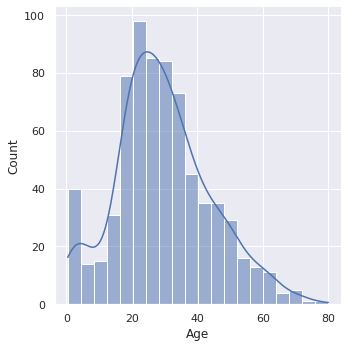

In [39]:
sns.displot(data=train_df, x="Age", kde=True)

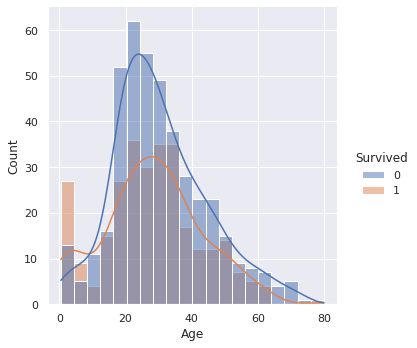

In [40]:
sns.displot(data=train_df, x="Age", kde=True, hue='Survived')

In [41]:
# there's some accumulation in the first years (kids), let's inspect this more carefully:
train_df.Age[train_df.Age < 15].value_counts().sort_index()

0.42      1
0.67      1
0.75      2
0.83      2
0.92      1
1.00      7
2.00     10
3.00      6
4.00     10
5.00      4
6.00      3
7.00      3
8.00      4
9.00      8
10.00     2
11.00     4
12.00     1
13.00     2
14.00     6
14.50     1
Name: Age, dtype: int64

While this is a clearly bimodal distribution there is no clear justification for a special encoding. If neeeded, the entire set can be then standardized.

In [42]:
passthrough_vars.append('Age')

### SibSp

As it is already known that it doesn't work well at least as a standalone predictor, one last effort is done by finding out whether 0 vs 1+ SibSp/Parch is a more meaningful encoding.

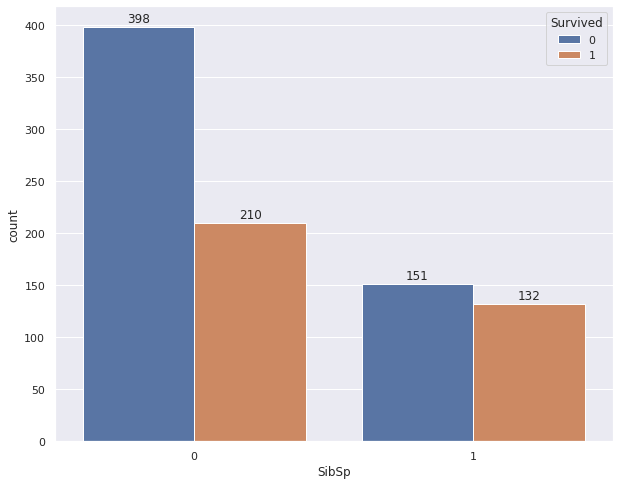

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x=(train_df.SibSp > 0).astype(int), hue=train_df.Survived, ax=ax)
annotate_bars(ax)
plt.show()

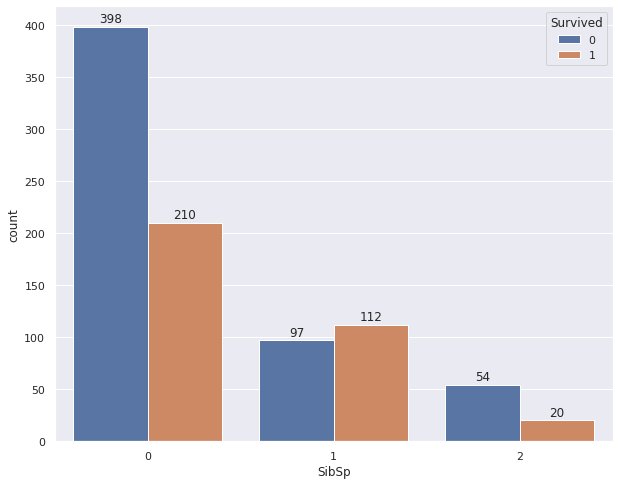

In [44]:
# 0 vs 1 looked better, try 0,1,2
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x=train_df.SibSp.clip(lower=0, upper=2), hue=train_df.Survived, ax=ax)
annotate_bars(ax)
plt.show()

In [45]:
class ColumnClipper(BaseEstimator, TransformerMixin):
    def __init__(self, minval, maxval,name=""):
        self.minval = minval
        self.maxval = maxval
        self.name = name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.clip(lower=self.minval, upper=self.maxval).to_frame(name=self.get_feature_names()[0])
    
    def get_feature_names(self):
        return ["clipped_"+self.name]

In [46]:
ColumnClipper(0,2,name="sibsp").transform(train_df.SibSp).value_counts()

clipped_sibsp
0                608
1                209
2                 74
dtype: int64

In [47]:
# add it to the pipeline
pipeline_transformers.append(
    ('sibsp-clipper', ColumnClipper(0,2,name="sibsp"), "SibSp")
)

### Parch

Same as with *SibSp*

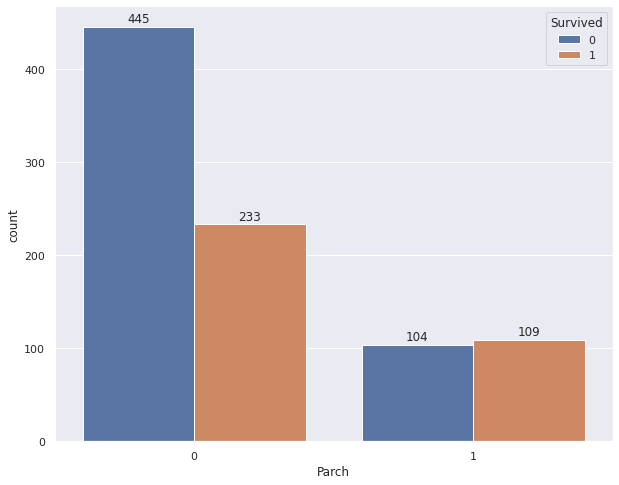

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x=(train_df.Parch > 0).astype(int), hue=train_df.Survived, ax=ax)
annotate_bars(ax)
plt.show()

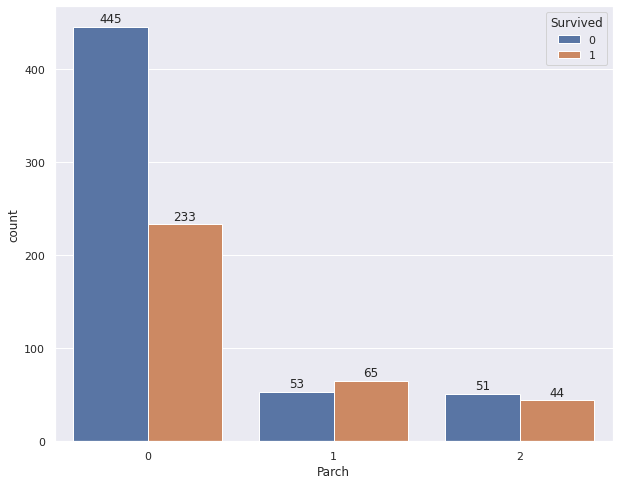

In [49]:
# again 0 vs 1 looked better, try 0,1,2
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x=train_df.Parch.clip(lower=0, upper=2), hue=train_df.Survived, ax=ax)
annotate_bars(ax)
plt.show()

Now the \[0,2] clipping doesnt improve on the \[0,1] one, so we keep the latter. It seems that SibSp=1 is special because it could be an indicator of an adult couple, while having at least one parent/children is already indicator of a family (Parch=1), therefore 2+ not adding much information over that.

In [50]:
# add it to the pipeline
pipeline_transformers.append(
    ('parch-clipper', ColumnClipper(0,1,name="parch"), "Parch")
)

### Ticket

This is the ticket number and as such, has some information that might be useful but requires some very specific parsing.

In [51]:
train_df.Ticket.value_counts().sort_values(ascending=False)

347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
2683                1
SOTON/O2 3101287    1
11774               1
392092              1
370376              1
Name: Ticket, Length: 681, dtype: int64

In [52]:
train_df.Ticket.head(10)

PassengerId
1            A/5 21171
2             PC 17599
3     STON/O2. 3101282
4               113803
5               373450
6               330877
7                17463
8               349909
9               347742
10              237736
Name: Ticket, dtype: object

As seen, not only is the format inconsistent but also numbers most likely don't translate into any meaningful information. There is a chance that some locality-based feature has predictive power, but the model is far simpler without this feature.

In [53]:
drop_vars.append('Ticket')

### Fare

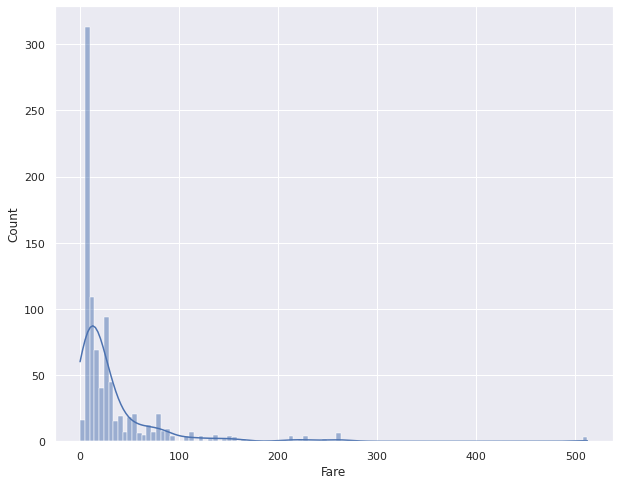

In [54]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=train_df, x='Fare', kde=True)
plt.show()

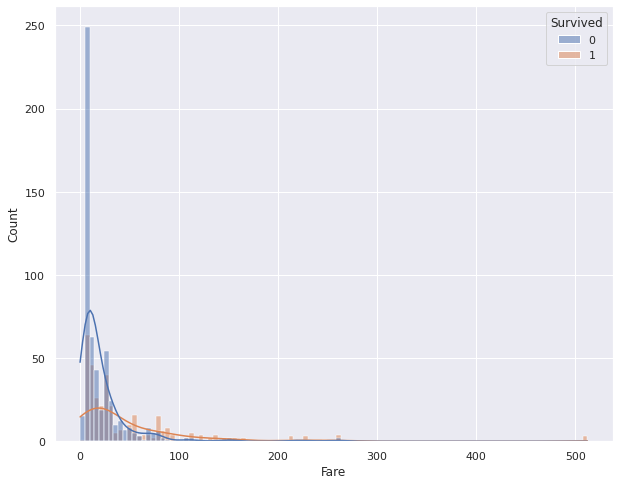

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=train_df, x='Fare', hue='Survived', kde=True)
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


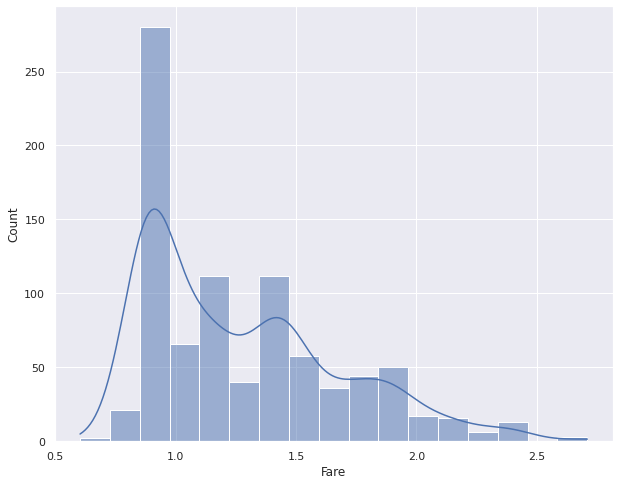

In [56]:
# trying with log-scaled fare to cope with the long, not-so-small tail
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(x=np.log10(train_df.Fare), kde=True)
plt.show()

In [57]:
# even if it can be seen in the describe() method, it's weird for Fare to be 0. Is this a common problem?
sum(train_df.Fare==0)

15

In [58]:
# is the next value in the cents? or goes up to probably the min-fare ticket 
np.min(train_df.Fare[train_df.Fare>0])

4.0125

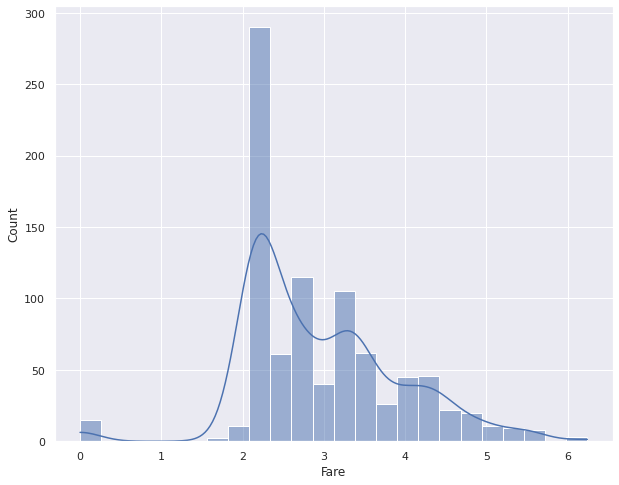

In [59]:
# so the free ticket is fairly uncommon, but definitely not unique to a single observation
# also next smallest value is 4

# using shifted log scale now
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(x=np.log1p(train_df.Fare), kde=True)
plt.show()

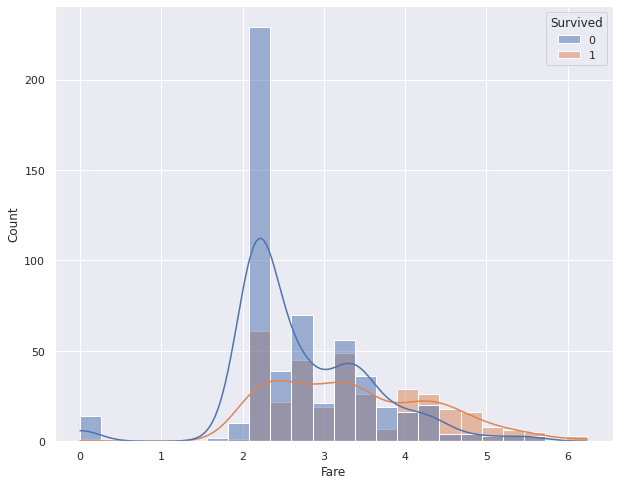

In [60]:
# disaggregating by Survival
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(x=np.log1p(train_df.Fare), hue=train_df.Survived, kde=True)
plt.show()

In [61]:
# using FunctionTransformer for this, because whatever

class NamedFunctionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, fun, names):
        self.fun = fun
        self.names = names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = self.fun(X)
        return result if type(result) is pd.DataFrame else result.to_frame()
    
    def get_feature_names(self):
        return self.names


log1pTransformer = NamedFunctionTransformer(np.log1p, names=["shifted_fare"])

In [62]:
log1pTransformer.transform(train_df.Fare)

,Fare
PassengerId,
1,2.110213
2,4.280593
3,2.188856
4,3.990834
5,2.202765
...,...
887,2.639057
888,3.433987
889,3.196630


In [63]:
# add it to the pipeline
pipeline_transformers.append(
    ("log-fare",log1pTransformer,["Fare"])
)

### Cabin

This feature is not only absent in over 75% of the observations, of the 891-687=204 observations where it's present, 147 of them are unique values (72% uniqueness). Imputing values based on only 1/4 of the dataset adds more variance in the prediction than the predicion power obtained from this feature. Proceeding to drop it.

In [64]:
drop_vars.append('Cabin')

### Embarked


<AxesSubplot:xlabel='Embarked', ylabel='count'>

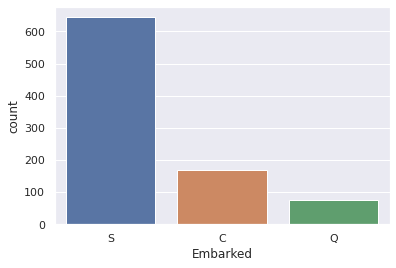

In [65]:
sns.countplot(data=train_df, x="Embarked")

<AxesSubplot:xlabel='Embarked', ylabel='count'>

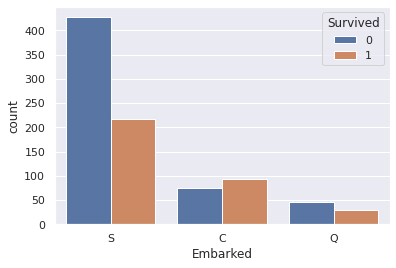

In [66]:
sns.countplot(data=train_df, x="Embarked", hue='Survived')

As seen before, C and Q values for *Embarked* seem to be good while S is not that far off from the average ratio. One-hot encoding of this feature while dropping the first class is the selected option.

In [67]:
pipeline_transformers.append(
    ('one-hot-embarked', OneHotEncoder(sparse=False, handle_unknown='error',drop='first'), ['Embarked'])
)

## Training pipeline: Baseline Model + Evaluation Pipeline + Submission generation

### Imputation

Need to impute:

* *Fare*, which is a moderately long-tailed continuous variable -> median
* *Age*, same as above
* *Embarked*, a nominal categorical variable -> mode

In [68]:
# a OOP oriented pipeline of SimpleImputers that returns a dataframe (keeps labels)
class DataFrameSimpleImputer:
    def __init__(self, imputation_dict):
        """Imputation_dict must be of the form {strategy: list_of_features_for_strat}, e.g. {'mean':['Age']}"""
        self.p = ColumnTransformer(transformers=[
            (strat, SimpleImputer(strategy=strat), features) for strat, features in imputation_dict.items()], 
                                   remainder='passthrough')
        # this columns will be the left-most in the transformed dataframes
        self.imputed_columns = sum(imputation_dict.values(),[])
        
    def fit(self, X, y=None):
        return self.p.fit(X,y)
    
    def _restore_df(self, X, imputed_X):
        # left-most cols are imputed ones, then all the others in order of appearance
        set_imputed_cols = set(self.imputed_columns)
        passthrough_cols = [col for col in X.columns if col not in set_imputed_cols]
        
        # build df and restore index, column labels and re-infer dtypes
        return (pd.DataFrame(imputed_X,
                           index=X.index,
                           columns=self.imputed_columns + passthrough_cols)
                .infer_objects()
               )
        
    def transform(self, X):
        imputed_mat = self.p.transform(X)
        return self._restore_df(X, imputed_mat)
    
    def fit_transform(self, X, y=None):
        imputed_mat = self.p.fit_transform(X, y)
        return self._restore_df(X, imputed_mat)

In [69]:
# show usage
imputer = DataFrameSimpleImputer({'median':['Age','Fare'], 'most_frequent':['Embarked']})
imputer.fit_transform(train_df.drop(columns=["Survived"])).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       891 non-null    float64
 1   Fare      891 non-null    float64
 2   Embarked  891 non-null    object 
 3   Pclass    891 non-null    int64  
 4   Name      891 non-null    object 
 5   Sex       891 non-null    object 
 6   SibSp     891 non-null    int64  
 7   Parch     891 non-null    int64  
 8   Ticket    891 non-null    object 
 9   Cabin     204 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 108.9+ KB


In [70]:
imputer.transform(test_df).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       418 non-null    float64
 1   Fare      418 non-null    float64
 2   Embarked  418 non-null    object 
 3   Pclass    418 non-null    int64  
 4   Name      418 non-null    object 
 5   Sex       418 non-null    object 
 6   SibSp     418 non-null    int64  
 7   Parch     418 non-null    int64  
 8   Ticket    418 non-null    object 
 9   Cabin     91 non-null     object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


## Encoding

Done through a simple ColumnTransformer thanks to previous lists *passthrough_vars*, *drop_vars* and *pipeline_transformers*.

In [71]:
encoder = ColumnTransformer(transformers=[('passthrough','passthrough',passthrough_vars),
                                               ('drop','drop',drop_vars)]  + pipeline_transformers)


# show usage on fake DF without missing data
fake_df = train_df.dropna()

encoded_mat = encoder.fit_transform(fake_df.drop(columns=['Survived']), fake_df.Survived)
encoded_df = pd.DataFrame(encoded_mat, columns=encoder.get_feature_names())
encoded_df

,Pclass,Age,name-to-title__title_master,name-to-title__title_miss,name-to-title__title_mr,name-to-title__title_mrs,name-to-title__title_other,sex-encoder__is_female,sibsp-clipper__clipped_sibsp,parch-clipper__clipped_parch,log-fare__shifted_fare,one-hot-embarked__x0_Q,one-hot-embarked__x0_S
0,1.0,38.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,4.280593,0.0,0.0
1,1.0,35.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,3.990834,0.0,1.0
2,1.0,54.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.967694,0.0,1.0
3,3.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.873565,0.0,1.0
4,1.0,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.316003,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1.0,47.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.980694,0.0,1.0
179,1.0,33.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.791759,0.0,1.0
180,1.0,56.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.432700,0.0,0.0
181,1.0,19.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.433987,0.0,1.0


In [72]:
encoded_df.columns

Index(['Pclass', 'Age', 'name-to-title__title_master',
       'name-to-title__title_miss', 'name-to-title__title_mr',
       'name-to-title__title_mrs', 'name-to-title__title_other',
       'sex-encoder__is_female', 'sibsp-clipper__clipped_sibsp',
       'parch-clipper__clipped_parch', 'log-fare__shifted_fare',
       'one-hot-embarked__x0_Q', 'one-hot-embarked__x0_S'],
      dtype='object')

In [73]:
# can't use a Pipeline because this version of Sk Learn insists on dropping all feature names
class Preprocessor:
    def __init__(self,imputer,encoder, dropper):
        self.p = Pipeline(steps=[('imputation', imputer),
                                 ('encoding', encoder)])
        self.dropper = dropper
        
    def fit_transform(self, X, y=None):
        aux = self.p.fit_transform(X, y)
        aux_df = pd.DataFrame(aux, index=X.index, columns=self.p[-1].get_feature_names())
        return self.dropper.transform(aux_df).infer_objects()
    
    def transform(self, X):
        aux = self.p.transform(X)
        aux_df = pd.DataFrame(aux, index=X.index, columns=self.p[-1].get_feature_names())
        return self.dropper.transform(aux_df).infer_objects()

preprocessor = Preprocessor(imputer=imputer, 
                            encoder=encoder, 
                            dropper=ColumnDropper(cols=['name-to-title__title_other']))

In [74]:
TARGET_VAR = 'Survived'
X_train = train_df.drop(columns=[TARGET_VAR])
y_train = train_df[TARGET_VAR]
X_test = test_df

# encode
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

### Baseline Model and Evaluation pipeline

Since the competition' selected metric is *accuracy*, so will be for us.

In [75]:
def eval_model(model, name, kfolds=5):
    scores =  cross_val_score(model, X_train, y_train, cv=kfolds, scoring='accuracy',n_jobs=-1)
    print(f"Accuracy for {name}: mean={scores.mean():.3f}, 1se={scores.mean()-scores.std():.3f}")
    return scores

# test it
RNG_SEED = 45
baseline_model = RandomForestClassifier(random_state=RNG_SEED)

scores_baseline = eval_model(baseline_model, 'baseline RF')

Accuracy for baseline RF: mean=0.805, 1se=0.768


The baseline model, which is an out-of-the-box RandomForestClassifier has a decent performance of ~0.8 (unbiased CV estimate) accuracy, with a 1-SE accuracy of 0.768.
Now we will produce a submission to get that out of the way, and proceed to optimize hyperparameters.

### Submission generation

In [76]:
def submit_model(model, name, also_train=False):
    # train model on full data if needed
    if also_train:
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    filename=name+".csv"
    
    pd.DataFrame({
        "PassengerId": X_test.index.to_list(),
        TARGET_VAR: predictions
    }).to_csv(filename,index=False)

In [77]:
submit_model(baseline_model, 'baseline',also_train=True)

This baseline gets a score of $0.74401$ in the leaderboard, which is similar to the $1_{SE}$ CV-estimated accuracy score.

## Model search

In [78]:
# downgrading version of hyperopt per https://github.com/hyperopt/hyperopt-sklearn/issues/179
!pip install hyperopt==0.2.5

     |████████████████████████████████| 965 kB 242 kB/s            
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7


In [79]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-1nxt12m3
  Running command git clone --filter=blob:none -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-1nxt12m3
  Resolved https://github.com/hyperopt/hyperopt-sklearn to commit c66f8df76003b5e72cb242399eeb139f951a1883
  Preparing metadata (setup.py) ... - done
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=27009 sha256=43b10e43fb504c8d87b9149ab7f707682400fff528dbe4d2c5914067be03f624
  Stored in directory: /tmp/pip-ephem-wheel-cache-6r0yyk5n/wheels/4b/06/53/c35e360ca94aa0ab93518bf53abe5fb270c95dbe56b8e2e76b
Successfully built hpsklearn
  Attempting uninstall: hpsklearn
    Found existing installation: hpsklearn 0.1.0
    Uninstalling hpsklearn-0.1.0:
      Successfully uninstalled hpsklearn-0.1.0


In [80]:
# more imports, now based on models
import xgboost as xgb
import hyperopt as hp

print("Hyperopt version:",hp.__version__)

Hyperopt version: 0.2.5


### HPSklearn 

This experimental library uses *HyperOpt* and a list of predefined search spaces for each of the models to look for either just the best hyperparameters or even the model.

In [81]:
from hpsklearn import HyperoptEstimator, extra_trees, xgboost_classification

extra_trees_estim = HyperoptEstimator(classifier=extra_trees('extra-trees'),
                                      algo=hp.tpe.suggest,
                                      max_evals=100,
                                      trial_timeout=360)

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [82]:
# fit the extra trees estimator
extra_trees_estim.fit(X_train.to_numpy(), y_train.to_numpy(), n_folds=5)

# print best model
hpskl_extra_trees_best_model = extra_trees_estim.best_model()['learner']
print(hpskl_extra_trees_best_model)

100%|██████████| 100/100 [00:00<00:00,  2.16trial/s, best loss: 0.17059483726150393]
ExtraTreesClassifier(bootstrap=True, max_features=0.43487647864479484,
                     min_samples_leaf=3, n_estimators=11, n_jobs=1,
                     random_state=4, verbose=False)


In [83]:
eval_model(model=hpskl_extra_trees_best_model,name='HPSKL Extra trees')

Accuracy for HPSKL Extra trees: mean=0.829, 1se=0.796


array([0.83240223, 0.8258427 , 0.86516854, 0.76966292, 0.85393258])

### XGBoost

In [84]:
# baseline XGBoost
"""
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test)

# refer to https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster
# for parameters
baseline_params={
    'max_depth':2, 
    'eta':0.5,
    'objective':'binary:logistic'
}

res = xgb.cv(baseline_params, dtrain, num_boost_round=5, nfold=5,
       seed=RNG_SEED,
       metrics={'logloss'},
       callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])
"""

xgb_estim = HyperoptEstimator(classifier=xgboost_classification('xgb-clf'),
                              algo=hp.tpe.suggest,
                              max_evals=10,
                              trial_timeout=360,
                              n_jobs=-1)

# Search the hyperparameter space based on the data
xgb_estim.fit(X_train.to_numpy(), y_train.to_numpy(),  n_folds=5)

hpskl_xgb = xgb_estim.best_model()['learner']

print(hpskl_xgb)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:44:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:44:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/1 [00:05<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:45:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/1 [00:10<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:45:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/1 [00:16<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:45:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:45:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:46:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:46:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|██████▋   | 2/3 [00:12<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:46:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|██████▋   | 2/3 [00:24<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|██████▋   | 2/3 [00:37<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|███████▌  | 3/4 [00:07<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|███████▌  | 3/4 [00:15<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 75%|███████▌  | 3/4 [00:22<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:47:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:48:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:48:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|████████  | 4/5 [00:06<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:48:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|████████  | 4/5 [00:13<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:48:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 80%|████████  | 4/5 [00:19<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:48:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:48:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:49:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:49:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|████████▌ | 6/7 [00:19<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:50:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|████████▌ | 6/7 [00:38<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:50:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 86%|████████▌ | 6/7 [00:57<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:50:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 88%|████████▊ | 7/8 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:50:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:52:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:53:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:53:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|█████████ | 9/10 [00:05<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:53:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|█████████ | 9/10 [00:11<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:53:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 90%|█████████ | 9/10 [00:18<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:53:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
100%|██████████| 10/10 [00:29<00:00, 29.03s/trial, best loss: 0.1582491582491582]
[17:53:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7569428504466125, colsample_bynode=1,
              colsample_bytree=0.6799178979413578, enable_categorical=False,
              gamma=0.11855551804480993, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.016447837295620424,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=4400, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0.3497897935717643, reg_lambda=1.504193641873445,
              scale_pos_weight=1, seed=1, subsample=0.5339001474235694,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [85]:
eval_model(model=hpskl_xgb,name='HPSKL XGB')

Accuracy for HPSKL XGB: mean=0.842, 1se=0.825


array([0.83798883, 0.8258427 , 0.87078652, 0.8258427 , 0.84831461])

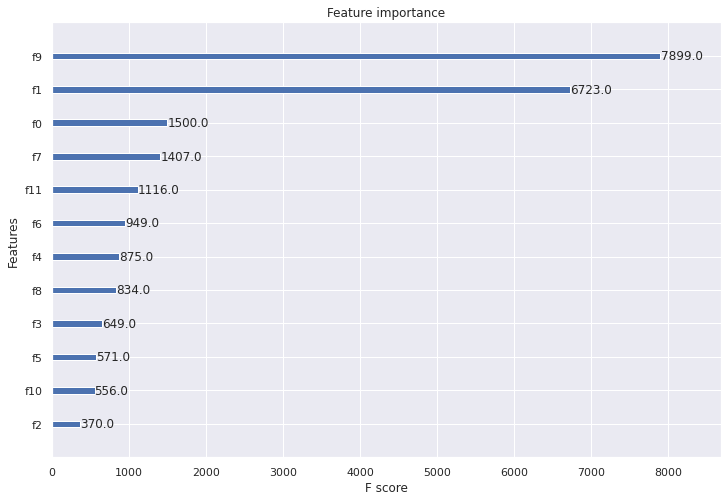

In [86]:
# plot
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(hpskl_xgb.get_booster(), ax=ax)
plt.show()

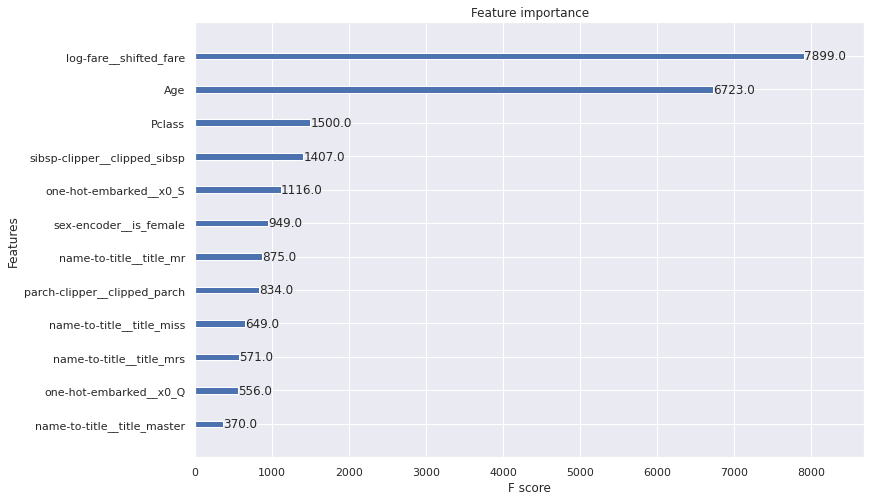

In [87]:
# redo with original Feature names
name_mapping = {f"f{idx}":feature_name for idx, feature_name in enumerate(X_train.columns)}

fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(hpskl_xgb.get_booster(), ax=ax)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([name_mapping[ticklabel.get_text()] for ticklabel in ax.get_yticklabels()])

plt.show()

In [88]:
# submit xgboost
submit_model(hpskl_xgb, 'hpskl-xgb',also_train=False)